In [1]:
# !pip install torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# !pip install functorch

# print("--> Restarting colab instance") 
# get_ipython().kernel.do_shutdown(True)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchmetrics import Accuracy

from functorch import make_functional_with_buffers, grad

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )
])

batch_size = 64
device = "cuda"

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


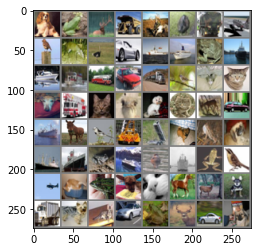

dog   frog  deer  truck deer  bird  truck plane bird  deer  bird  car   ship  ship  frog  ship  ship  ship  truck car   truck bird  cat   cat   dog   truck cat   bird  dog   cat   deer  car   ship  horse bird  truck truck dog   frog  dog   ship  ship  frog  ship  bird  ship  frog  bird  plane cat   frog  dog   cat   horse deer  dog   truck dog   cat   car   frog  deer  car   dog  


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Stateful PyTorch

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
def to_device(tensors, device="cpu"):
    "Put tensors on device"
    if isinstance(tensors, (list, tuple)):
        return tuple(to_device(t, device) for t in tensors)
    elif isinstance(tensors, torch.Tensor):
        return tensors.to(device)
    else:
        raise Exception("Not a torch tensor-ish")

In [8]:
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
metric = Accuracy().to(device)

In [9]:
for epoch in tqdm(range(5)):  # loop over the dataset multiple times
    metric.reset()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = to_device(data, device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc = metric(outputs, labels)

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch}] loss: {running_loss / 2000:.3f}, accuracy: {metric.compute():.3f}')

print('Finished Training')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[0] loss: 0.685, accuracy: 0.350


  0%|          | 0/782 [00:00<?, ?it/s]

[1] loss: 0.590, accuracy: 0.445


  0%|          | 0/782 [00:00<?, ?it/s]

[2] loss: 0.552, accuracy: 0.487


  0%|          | 0/782 [00:00<?, ?it/s]

[3] loss: 0.528, accuracy: 0.508


  0%|          | 0/782 [00:00<?, ?it/s]

[4] loss: 0.512, accuracy: 0.527
Finished Training


In [10]:
batch = next(iter(test_dataloader))
images, labels = to_device(batch, device)
preds = model(images).argmax(axis=1)
images, preds, labels = to_device([images, preds, labels], device="cpu")

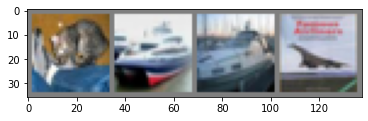

cat/cat   car/ship  ship/ship  ship/plane


In [11]:
# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{classes[preds[j]]}/{classes[labels[j]]:5s}' for j in range(4)))

# Functional PyTorch

In [12]:
model = Classifier().to(device=device)
functional_model, params, buffers = make_functional_with_buffers(model)
metric = Accuracy().to(device)

In [13]:
def sgd_optimizer(weights, gradients, learning_rate):
    return [weight - learning_rate * gradient for weight, gradient in zip(weights, gradients)]

In [14]:
def compute_stateless_loss(params, buffers, inputs, labels):
    # sample = sample.unsqueeze(0)
    # label = label.unsqueeze(0)
    outputs = functional_model(params, buffers, inputs)
    loss = F.cross_entropy(outputs, labels)
    return loss

compute_gradients = grad(compute_stateless_loss)

In [15]:
def functional_step(params, buffers, inputs, labels):
    gradients = compute_gradients(params, buffers, inputs, labels)
    updated_params = sgd_optimizer(params, gradients, 1e-2)
    return updated_params, buffers

In [16]:
def train(functional_step, params, buffers, metric):
    running_loss = 0.
    metric.reset()
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, labels = to_device(data, device)
        params, buffers = functional_step(params, buffers, inputs, labels)
        
        # new forward
        outputs = functional_model(params, buffers, inputs)
        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        metric(outputs, labels)
        
    return params, buffers, running_loss, metric

In [28]:
for epoch in range(5):
    params, buffers, running_loss, metric = train(functional_step, params, buffers, metric)
    print(f'[{epoch}] loss: {running_loss / 2000:.3f}, accuracy: {metric.compute():.3f}')

  0%|          | 0/782 [00:00<?, ?it/s]

[0] loss: 0.550, accuracy: 0.493


  0%|          | 0/782 [00:00<?, ?it/s]

[1] loss: 0.524, accuracy: 0.519


  0%|          | 0/782 [00:00<?, ?it/s]

[2] loss: 0.503, accuracy: 0.541


  0%|          | 0/782 [00:00<?, ?it/s]

[3] loss: 0.483, accuracy: 0.564


  0%|          | 0/782 [00:00<?, ?it/s]

[4] loss: 0.466, accuracy: 0.580


In [26]:
batch = next(iter(test_dataloader))
images, labels = to_device(batch, device)
preds = functional_model(params, buffers, images).argmax(axis=1)
images, preds, labels = to_device([images, preds, labels], device="cpu")

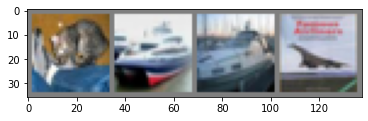

cat/cat   ship/ship  car/ship  ship/plane


In [27]:
# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{classes[preds[j]]}/{classes[labels[j]]:5s}' for j in range(4)))